In [23]:
import numpy as np
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)
print(data.shape)
print(data.columns)
data

(3941, 27)
Index(['id', 'mort_28', 'age', 'sex', 'weight', 'height', 'pf_ratio', 'po2',
       'pco2', 'ph', 'driving_pressure', 'lung_compliance', 'map', 'bilirubin',
       'creatinine', 'platelets', 'urea', 'fio2', 'hco3', 'heart_rate',
       'minute_volume', 'peep', 'plateau_pressure', 'respiratory_rate',
       'syst_blood_pressure', 'diastolic_blood_pressure', 'peep_regime'],
      dtype='object')


,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,False,75,F,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,low
1,34100191,False,47,M,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,low
2,38292466,False,85,M,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,low
3,32743332,False,85,M,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,low
4,35009126,True,64,M,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,32959861,True,78,F,57.0,160.0,157.178571,136.833333,38.083333,7.370833,...,65.454545,22.000000,95.785714,8.511111,6.800000,22.000000,16.677419,NaN,NaN,low
3937,32761676,False,75,M,101.0,178.0,179.909091,91.714286,39.000000,7.310000,...,52.142857,17.600000,60.394737,7.250000,5.000000,15.400000,16.795455,NaN,NaN,low
3938,34058245,True,67,F,100.0,165.0,158.331733,104.250000,43.250000,7.292500,...,77.142857,18.800000,122.041667,8.813333,16.700000,30.333333,25.290323,101.789474,59.631579,high
3939,34670930,False,68,M,94.7,163.0,192.500000,90.600000,40.400000,7.414000,...,60.000000,23.500000,65.807692,8.816667,9.166667,21.285714,21.531250,158.000000,83.500000,low


In [13]:
xs = data.copy()


y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 0 if x == False else 1, y))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
columns = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

imputer = KNNImputer(n_neighbors=2, weights="uniform")
xs = imputer.fit_transform(xs)

xs = pd.DataFrame(data=xs, columns=columns)

xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,75.0,1.0,93.0,168.0,241.944444,130.666667,28.111111,7.245556,11.000000,31.227273,...,83.000000,3.71280,50.000000,12.000000,115.408163,8.241111,24.333333,18.943662,100.600000,68.200000
1,47.0,0.0,127.0,183.0,166.356061,113.076923,34.461538,7.196923,8.350000,79.780702,...,19.600000,32.21925,68.500000,12.750000,115.407407,16.628571,17.500000,19.857143,99.000000,68.000000
2,85.0,0.0,77.5,170.0,224.000000,112.000000,38.000000,7.440000,17.250000,33.338235,...,124.500000,16.42200,51.818182,23.000000,70.041667,9.433333,22.333333,15.833333,102.000000,46.333333
3,85.0,0.0,90.7,170.0,205.714286,72.000000,38.000000,7.500000,17.000000,26.882353,...,200.000000,24.63300,36.875000,27.000000,70.480000,7.478571,24.000000,18.200000,108.083333,46.208333
4,64.0,0.0,70.0,183.0,173.777778,94.666667,38.666667,7.400000,8.585714,52.821226,...,513.666667,5.11700,52.500000,21.666667,73.955556,7.050000,14.328571,15.016667,103.415094,57.377358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,78.0,1.0,57.0,160.0,157.178571,136.833333,38.083333,7.370833,16.400000,26.829268,...,209.666667,14.63700,65.454545,22.000000,95.785714,8.511111,22.000000,16.677419,120.154762,68.684524
3937,75.0,0.0,101.0,178.0,179.909091,91.714286,39.000000,7.310000,10.400000,42.412137,...,78.200000,28.70280,52.142857,17.600000,60.394737,7.250000,15.400000,16.795455,94.786111,50.796528
3938,67.0,1.0,100.0,165.0,158.331733,104.250000,43.250000,7.292500,13.200000,25.796667,...,309.400000,15.06540,77.142857,18.800000,122.041667,8.813333,30.333333,25.290323,101.789474,59.631579
3939,68.0,0.0,94.7,163.0,192.500000,90.600000,40.400000,7.414000,12.500000,33.805421,...,151.200000,6.69375,60.000000,23.500000,65.807692,8.816667,21.285714,21.531250,158.000000,83.500000


In [14]:
y

0       0
1       0
2       0
3       0
4       1
       ..
3936    1
3937    0
3938    1
3939    0
3940    1
Length: 3941, dtype: int64

In [15]:
w

0       0
1       0
2       0
3       0
4       0
       ..
3936    0
3937    0
3938    1
3939    0
3940    0
Length: 3941, dtype: int64

In [18]:
full_data = xs.assign(W=w, Y=y)

train_x, test_x, train_w, test_w, train_y, test_y = train_test_split(xs, w, y, test_size=0.3)

In [20]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

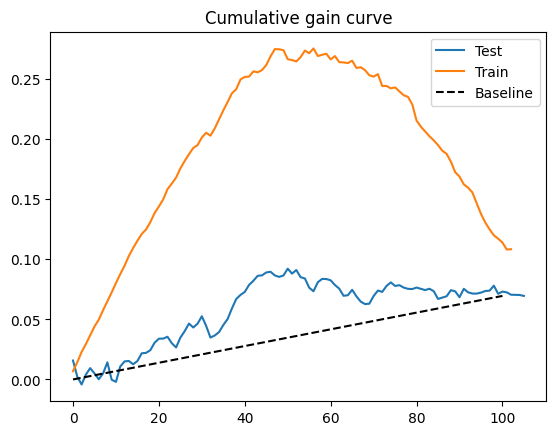

In [21]:
cau_forest = CausalForest()
cau_forest.fit(train_x, train_w, train_y)

causal_forest_cate_train = train_x.assign(cate=cau_forest.predict(train_x), W=train_w, Y=train_y)
causal_forest_cate_test = test_x.assign(cate=cau_forest.predict(test_x), W=test_w, Y=test_y)


gain_curve_test = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")
gain_curve_train = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test_x.assign(W=test_w, Y=test_y), "Y", "W")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("Cumulative gain curve")
plt.show()

In [33]:
causal_forest_cate_test

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,cate,W,Y
312,65.0,1.0,52.0,152.0,160.736111,121.800000,44.400,7.356000,10.516667,29.862526,...,22.250000,69.888889,8.742857,22.857143,29.617647,103.230769,63.730769,0.126670,0,0
1041,75.0,0.0,77.3,173.0,141.000000,121.000000,26.000,7.570000,10.866667,36.338305,...,24.500000,93.615385,8.028750,19.066667,27.115385,111.960000,69.720000,0.192197,0,1
1181,72.0,0.0,100.0,178.0,205.000000,82.000000,52.000,7.430000,12.100000,48.264463,...,30.333333,80.892857,12.150000,17.250000,21.742857,113.961538,55.230769,0.142017,0,0
2676,57.0,1.0,55.5,155.0,300.666667,242.750000,45.875,7.345000,9.508333,47.422065,...,21.500000,106.447368,7.633333,20.500000,14.583333,117.863636,63.659091,0.061951,0,0
2397,56.0,0.0,227.0,176.5,200.000000,97.500000,42.500,7.380000,14.091071,31.535096,...,24.000000,96.916667,11.585714,26.381250,15.064516,117.708333,59.166667,0.046072,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,83.0,1.0,54.0,155.0,372.291667,158.000000,53.800,7.320000,9.625000,50.835031,...,26.250000,100.309524,8.812500,24.250000,22.740000,98.000000,48.000000,0.035348,0,0
3111,24.0,0.0,87.5,178.0,132.500000,98.600000,34.200,7.374000,10.500000,58.622727,...,22.000000,105.906250,13.728571,15.250000,23.256410,157.000000,65.500000,0.013543,0,0
2644,36.0,0.0,104.1,173.0,160.000000,78.000000,51.000,7.270000,11.128571,43.956170,...,22.333333,127.240000,11.070000,31.000000,17.342857,145.320000,87.200000,0.033304,1,0
2415,79.0,1.0,64.0,160.0,179.466667,127.888889,39.800,7.342000,15.500000,21.606049,...,23.800000,86.142857,6.633333,22.400000,18.888889,86.176471,48.000000,0.250898,0,0


In [31]:
explainer = shap.Explainer(cau_forest)
shap_values = explainer(xs)
shap_values


.values =
array([[-0.00494161, -0.00341659, -0.00575042, ..., -0.0065358 ,
         0.00616685, -0.00283862],
       [-0.00629699,  0.00043796,  0.00880492, ...,  0.00173462,
         0.00963913, -0.00289353],
       [-0.00380115,  0.00060175, -0.00580619, ..., -0.0123581 ,
         0.00028043,  0.00865644],
       ...,
       [ 0.01113905, -0.00175347,  0.01100019, ...,  0.0089532 ,
         0.00734266, -0.00171153],
       [ 0.01319447,  0.00206585, -0.00555367, ..., -0.00517228,
        -0.01000677, -0.00622018],
       [ 0.00855943,  0.00206423,  0.0003846 , ..., -0.00836502,
        -0.00161554,  0.00286969]])

.base_values =
array([0.07319394, 0.07319394, 0.07319394, ..., 0.07319394, 0.07319394,
       0.07319394])

.data =
array([[ 75.        ,   1.        ,  93.        , ...,  18.94366197,
        100.6       ,  68.2       ],
       [ 47.        ,   0.        , 127.        , ...,  19.85714286,
         99.        ,  68.        ],
       [ 85.        ,   0.        ,  77.5       

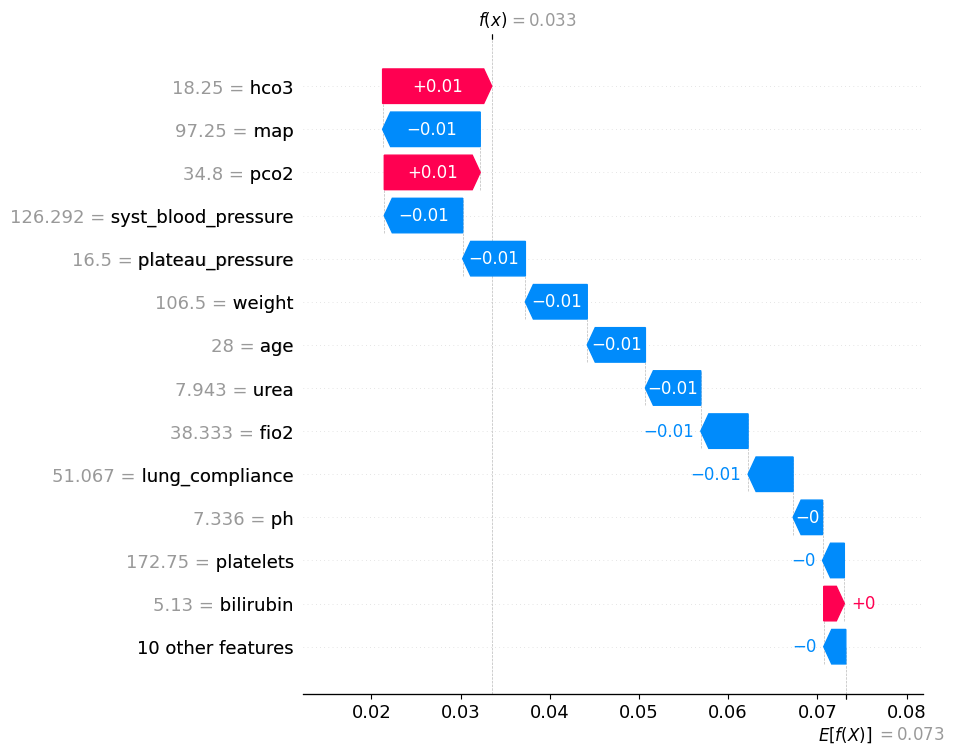

In [27]:
sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

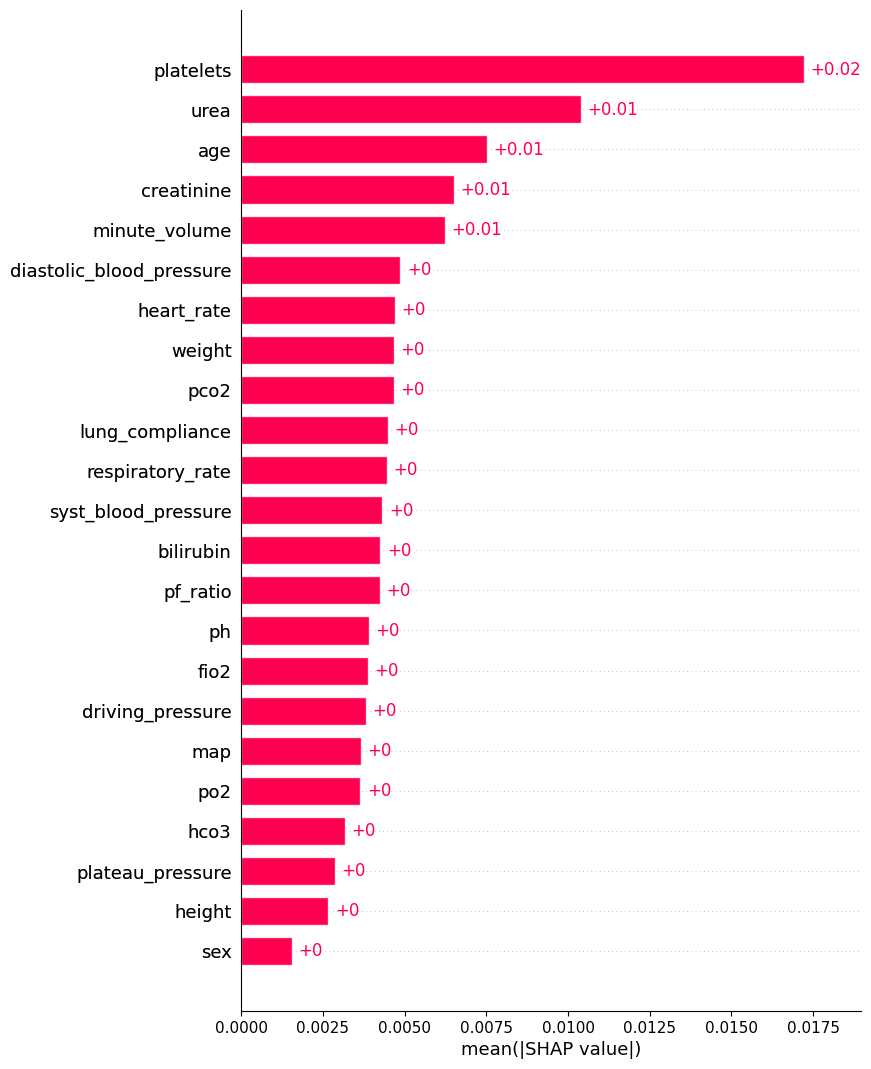

In [32]:
shap.plots.bar(shap_values, max_display=24)